In [62]:
# Setup
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
import sys
import requests
import io

# URL of the raw wave file on GitHub
# un-comment the URL of the file you want to use
# ATF Drums
#github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/Around%20the%20fur%20drums.wav"
# KYW inst
github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/KYW%20Inst.wav"

# Fetch the wave file from GitHub
response = requests.get(github_url)

# Check if the request was successful
if response.status_code == 200:
    # Read the wave data from the response content
    wave_data = io.BytesIO(response.content)
    
    # Read the wave file 
    fs, data = wavfile.read(wave_data)
    
else:
    print("Failed to fetch the wave file from GitHub")


# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

Min Value: -0.9484677314758301
Max Value: 0.9998999834060669


In [63]:
# Variables
corner_freq = 1000

bandwidth = 0.1 #in octaves

Q = 0.3


w0 = 2 * np.pi * (corner_freq/fs)

cos_w0 = np.cos(w0)

sin_w0 = np.sin(w0)

alpha_BW = (sin_w0) * np.sinh((np.log(2)/2) * bandwidth * (w0/sin_w0))

alpha_Q = (sin_w0)/(2 * Q)

In [64]:
# Notch filter Using Bandwidth - W3 EQ Cookbook

# Coefficients
b0_BW = 1
b1_BW = -2 * cos_w0
b2_BW = 1
a0_BW = 1 + alpha_BW
a1_BW = -2 * cos_w0
a2_BW = 1 - alpha_BW

num_BW = [b0_BW, b1_BW, b2_BW]
den_BW = [a0_BW, a1_BW, a2_BW]

w_BW, H_BW = signal.freqz(num_BW, den_BW)

In [65]:
# Notch filter Using Q - W3 EQ Cookbook

# Coefficients
b0_Q = 1
b1_Q = -2 * cos_w0
b2_Q = 1
a0_Q = 1 + alpha_Q
a1_Q = -2 * cos_w0
a2_Q = 1 - alpha_Q

num_Q = [b0_Q, b1_Q, b2_Q]
den_Q = [a0_Q, a1_Q, a2_Q]

w_Q, H_Q = signal.freqz(num_Q, den_Q)

In [66]:
# Butterworth implementation (2 pole)

start_stop = [corner_freq - 300, corner_freq + 300]

b_2, a_2 = signal.butter(2, start_stop, 'bandstop', fs=fs)

w_2, H_2 = signal.freqz(b_2, a_2)

In [67]:
# Butterworth implementation (3 pole)

b_3, a_3 = signal.butter(3, start_stop, 'bandstop', fs=fs)

w_3, H_3 = signal.freqz(b_3, a_3)

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_11839/2658507555.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, fs/2])  # Set x-axis limits
/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_11839/2658507555.py:34: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, fs/2])  # Set x-axis limits


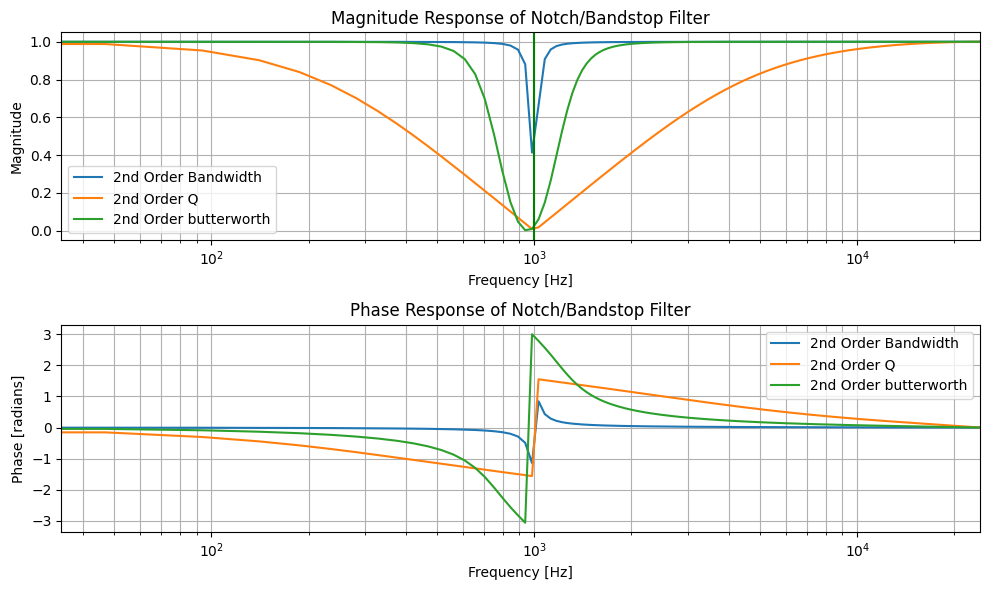

In [68]:
freq_hz_BW = w_BW * (fs / (2 * np.pi))

freq_hz_Q = w_Q * (fs / (2 * np.pi))

freq_hz_2p = w_2 * (fs / (2 * np.pi))

freq_hz_3p = w_3 * (fs / (2 * np.pi))

# Plot magnitude and phase responses in Hz
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(freq_hz_BW, np.abs(H_BW), label='2nd Order Bandwidth')
plt.plot(freq_hz_Q, np.abs(H_Q), label='2nd Order Q')
plt.plot(freq_hz_2p, np.abs(H_2), label='2nd Order butterworth')
plt.title('Magnitude Response of Notch/Bandstop Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(which='both')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits
plt.axvline(corner_freq, color='green')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(freq_hz_BW, np.angle(H_BW), label='2nd Order Bandwidth')
plt.plot(freq_hz_Q, np.angle(H_Q), label='2nd Order Q')
plt.plot(freq_hz_2p, np.angle(H_2), label='2nd Order butterworth')
plt.title('Phase Response of Notch/Bandstop Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')
plt.grid(which='both')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits
plt.legend()


plt.tight_layout()
plt.show()

In [69]:
output = signal.lfilter(num_Q, den_Q, data)

In [70]:
sd.play(output, fs)

In [71]:
#Write to wav file
#sf.write('Notch_KYW.wav', output, fs)